In [1]:
import csv
import math

import pandas as pd
import requests
import numpy as np

### Dataset Location
The Dataset cannot be pushed to Github. Github has decreased the allowed file size so the dataset will have to be downloaded manually.

The url is: https://data.cms.gov/provider-data/sites/default/files/resources/69a75aa9d3dc1aed6b881725cf0ddc12_1671768321/DAC_NationalDownloadableFile.csv

The Data Dictionary for this section of datasets: https://data.cms.gov/provider-data/sites/default/files/data_dictionaries/physician/DOC_Data_Dictionary.pdf

The webpage for this section of datasets: https://data.cms.gov/provider-data/topics/doctors-clinicians

In [2]:
df = pd.read_csv('DAC_NationalDownloadableFile.csv', encoding='windows-1252', dtype='string')

### Filtering and Cleaning the Dataset

In [3]:
# NOTE: Optimize This
speciality_locations = df[['adr_ln_1', 'cty', 'st', 'zip','pri_spec']]
speciality_locations = speciality_locations.replace(r'^s*$', np.nan, regex=True)
speciality_locations.dropna(inplace=True)
speciality_locations['latitude'] = speciality_locations['longitude'] = np.nan
print(speciality_locations.head())
print('Number of entries:',speciality_locations.shape[0])

             adr_ln_1             cty  st        zip                pri_spec  \
0     1582 N BROAD ST        TAZEWELL  TN  378794352      NURSE PRACTITIONER   
1   5632 ANNAPOLIS RD     BLADENSBURG  MD  207102213      NURSE PRACTITIONER   
2    611 E CARLSON ST        CHEYENNE  WY  820094335       INTERNAL MEDICINE   
3         30 RIVER ST      JIM THORPE  PA  182292313            CHIROPRACTIC   
4  20501 VENTURA BLVD  WOODLAND HILLS  CA  913640847  CLINICAL SOCIAL WORKER   

   latitude  longitude  
0       NaN        NaN  
1       NaN        NaN  
2       NaN        NaN  
3       NaN        NaN  
4       NaN        NaN  
Number of entries: 2472219


In [4]:
#Printing Unique Primary Specialites to Filter From
print(speciality_locations['pri_spec'].unique())

<StringArray>
[                                     'NURSE PRACTITIONER',
                                       'INTERNAL MEDICINE',
                                            'CHIROPRACTIC',
                                  'CLINICAL SOCIAL WORKER',
                                               'OPTOMETRY',
                                          'ANESTHESIOLOGY',
                                         'FAMILY PRACTICE',
                                               'NEUROLOGY',
                                   'CLINICAL PSYCHOLOGIST',
                                             'DERMATOLOGY',
                                        'PHYSICAL THERAPY',
                                           'OPHTHALMOLOGY',
                                      'ORTHOPEDIC SURGERY',
                                             'HOSPITALIST',
                                              'PSYCHIATRY',
                                            'ORAL SURGERY',
                          

In [5]:
#Selecting the specialites to use from the pri_spec column by removing the extranious specialites 
specialites_to_remove = [
    'CLINICAL SOCIAL WORKER',
    'UNDEFINED NON-PHYSICIAN TYPE (SPECIFY)',
    'UNDEFINED PHYSICIAN TYPE (SPECIFY)',
    'MEDICAL GENETICS AND GENOMICS',
    'MEDICAL TOXICOLOGY',
    'MASS IMMUNIZATION ROSTER BILLER'
]
indexes_to_remove = speciality_locations[ speciality_locations['pri_spec'].isin(specialites_to_remove) ].index
speciality_locations.drop(indexes_to_remove, inplace=True)
speciality_locations.reset_index(inplace=True)

In [6]:
batches = math.ceil(speciality_locations.shape[0] / 10000)
print(batches)

242


### Steps to Get Geolocations of Addresses in Batch
1. Create a loop that generates a CSV for each 247 entries 
2. Send the generated CSV to the Census GOV Geolocation API for processing
3. Recieve the response and append it to a local CSV 
4. Rinse and repeat until all addresses are converted to geolocations (lat. and long.) to use with a map

### Testing using Test Address

In [7]:
URL = 'https://geocoding.geo.census.gov/geocoder/locations/addressbatch'
with open('test_addresses.csv', 'rb') as input_file:
    geo = requests.post(files={'addressFile': input_file}, url=URL, data={'benchmark':'Public_AR_Current'})

In [8]:
response_content = str(geo.content)
print(response_content)

b'"000001","5632 ANNAPOLIS RD,  BLADENSBURG,  MD,  207102213","Match","Exact","5632 ANNAPOLIS RD, BLADENSBURG, MD, 20710","-76.92014292199997,38.93927167000004","641062561","L"\n'


### Extracting out the latitude and Longitude from the Test Address

In [9]:
lat, long = response_content.split('","')[5].split(',')  # Pretty hardcoded, but it works
print("lat: ", lat, "long: ", long)

lat:  -76.92014292199997 long:  38.93927167000004


### Example Test Address Plotting Using Geopandas

In [10]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import io
import time

<AxesSubplot: >

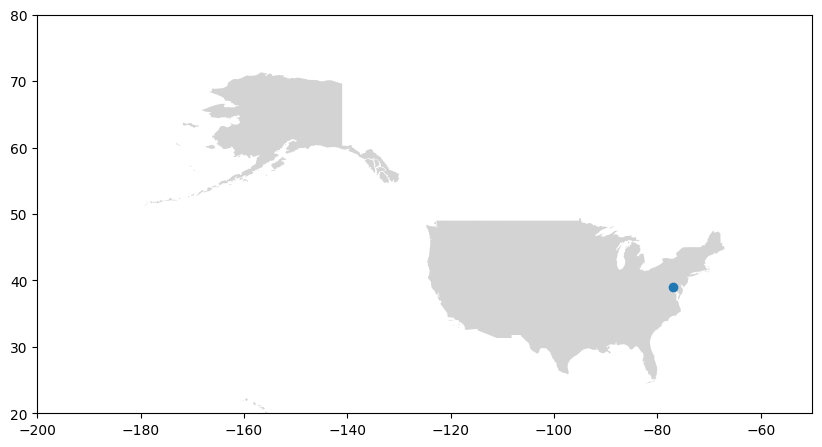

In [11]:
us_nation_map = gpd.read_file('./cb_2021_us_nation_20m/cb_2021_us_nation_20m.shp')

fig, ax = plt.subplots(figsize=(10, 10))
us_nation_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')

ax.set_xlim(-200, -50)
ax.set_ylim(20, 80)

crs = 'EPSG:4326'
geometry = [Point(float(lat), float(long))]
geo_df = gpd.GeoDataFrame(pd.DataFrame(), crs=crs, geometry=geometry)
geo_df.plot(ax=ax)

### Test Batching

In [12]:
test_batch_size = 150
csv_headers = ['adr_ln_1', 'cty', 'st', 'zip']
speciality_locations[:test_batch_size].to_csv('batched_addresses_test.csv', columns=csv_headers, header=None)

URL = 'https://geocoding.geo.census.gov/geocoder/locations/addressbatch'
with open('batched_addresses_test.csv', 'rb') as input_file:
    geo = requests.post(files={'addressFile': input_file}, url=URL, data={'benchmark':'Public_AR_Current'})
print(str(geo.content)[0:500])

b'"88","57 CROTON AVE, OSSINING, NY, 105624981","Match","Exact","57 CROTON AVE, OSSINING, NY, 10562","-73.83964526899996,41.16813971200003","139839620","L"\n"89","26717 WESTHEIMER PKWY, KATY, TX, 774945374","Match","Exact","26717 WESTHEIMER PKWY, KATY, TX, 77494","-95.81078320499995,29.760823293000044","78323461","R"\n"110","2633 NAPOLEON AVE, NEW ORLEANS, LA, 701157420","Match","Exact","2633 NAPOLEON AVE, NEW ORLEANS, LA, 70115","-90.10297243099996,29.93659863000005","191711724","R"\n"111","440


NOTE: the issue with the large batches wasn't the size, it was that non-matches were given with a smaller number of cols (3), than the 8 usual cols for a exact or non-exact match...therefore needed to manually specify column names to inset NaN values in the non-matches for the missing cols

NOTE: THE RESPONSE IS NOT IN THE CORRECT ORDER OF THE REQUEST!

In [13]:
print(str(geo.content)[:500])
names = [
    'id',
    'given_address',
    'match',
    'match_level',
    'official_address',
    'long_lat',
    'tertiary_coord',
    'letter'
]
 # from: https://github.com/msjopyho/NationalDocDatasetProject/blob/main/NationalDocDatasetProject.ipynb
gdf = pd.read_csv(io.StringIO(geo.text.strip('\n')), sep=',', header=None, quoting=csv.QUOTE_ALL, index_col= False, names=names)
gdf.sort_values(by=['id'], inplace=True)
gdf.reset_index(drop=True, inplace=True)
print('Before na drop:', gdf.shape)
gdf.to_csv('debug_response.csv')
clean_gdf = gdf.copy()
clean_gdf[['latitude', 'longitude']] = clean_gdf['long_lat'].astype(str).str.split(',', expand=True).astype(float)
print(clean_gdf.head())

b'"88","57 CROTON AVE, OSSINING, NY, 105624981","Match","Exact","57 CROTON AVE, OSSINING, NY, 10562","-73.83964526899996,41.16813971200003","139839620","L"\n"89","26717 WESTHEIMER PKWY, KATY, TX, 774945374","Match","Exact","26717 WESTHEIMER PKWY, KATY, TX, 77494","-95.81078320499995,29.760823293000044","78323461","R"\n"110","2633 NAPOLEON AVE, NEW ORLEANS, LA, 701157420","Match","Exact","2633 NAPOLEON AVE, NEW ORLEANS, LA, 70115","-90.10297243099996,29.93659863000005","191711724","R"\n"111","440
Before na drop: (150, 8)
   id                                  given_address  match match_level  \
0   0       1582 N BROAD ST, TAZEWELL, TN, 378794352  Match   Non_Exact   
1   1  5632 ANNAPOLIS RD, BLADENSBURG, MD, 207102213  Match       Exact   
2   2      611 E CARLSON ST, CHEYENNE, WY, 820094335  Match   Non_Exact   
3   3         30 RIVER ST, JIM THORPE, PA, 182292313  Match       Exact   
4   4     87 GREENWICH AVE, GREENWICH, CT, 068305521  Match       Exact   

                       

In [14]:
print(gdf[~gdf.index.isin(clean_gdf.index)].index)
print(clean_gdf.index)


Int64Index([], dtype='int64')
RangeIndex(start=0, stop=150, step=1)


In [15]:
# Testing out df merging
sample_speciality_locations = speciality_locations[:150].copy()
sample_speciality_locations.iloc[clean_gdf.index, 6:8] = clean_gdf[['latitude','longitude']]
print(sample_speciality_locations.head())

   index           adr_ln_1          cty  st        zip            pri_spec  \
0      0    1582 N BROAD ST     TAZEWELL  TN  378794352  NURSE PRACTITIONER   
1      1  5632 ANNAPOLIS RD  BLADENSBURG  MD  207102213  NURSE PRACTITIONER   
2      2   611 E CARLSON ST     CHEYENNE  WY  820094335   INTERNAL MEDICINE   
3      3        30 RIVER ST   JIM THORPE  PA  182292313        CHIROPRACTIC   
4      5   87 GREENWICH AVE    GREENWICH  CT  068305521           OPTOMETRY   

     latitude  longitude  
0  -83.569737  36.450869  
1  -76.920143  38.939272  
2 -104.819619  41.171238  
3  -75.735089  40.868765  
4  -73.626464  41.029534  


### Batch Looping to get the Actual Data
NOTE: Lat and long need to be switched

In [16]:
batched_addresses_csv = 'batched_addresses.csv'
URL = 'https://geocoding.geo.census.gov/geocoder/locations/addressbatch'
benchmark = 'Public_AR_Current'
csv_headers = ['adr_ln_1', 'cty', 'st', 'zip']
response_col_names = [
    'id',
    'given_address',
    'match',
    'match_level',
    'official_address',
    'long_lat',
    'tertiary_coord',
    'letter'
]

start_index = 0
batch_size = 5000
batches = math.ceil(speciality_locations.shape[0] / batch_size)
total_time = 0

print(f'Length of dataset: {speciality_locations.shape[0]}')
print(f'Number of Batches: {batches}')
print(f'Estimated (crude) time to completion: {130 * batches / 3600:0.4f} hours')


for batch in range(batches):
    if start_index >= speciality_locations.shape[0]: break
    if start_index + batch_size >= speciality_locations.shape[0]: batch_size = speciality_locations.shape[0] - start_index
    start_time = time.perf_counter()
    # 1. Save the batch to the batched_addresses csv file
    speciality_locations[start_index:(batch_size + start_index)].to_csv(batched_addresses_csv, columns=csv_headers, header=None)
    # 2. Make the reqquest to the Census Bureau API
    with open(batched_addresses_csv, 'rb') as input_file:
        response = requests.post(files={'addressFile': input_file}, url=URL, data={'benchmark': benchmark})
    # 3. Converting the response to a clean dataframe
    coord_df = pd.read_csv(io.StringIO(response.text.strip('\n')), sep=',', header=None, quoting=csv.QUOTE_ALL, index_col= False, names=names)
    # 4. Extracting the longitude and latitude and appending to the coord_df dataframe
    # from: https://github.com/msjopyho/NationalDocDatasetProject/blob/main/NationalDocDatasetProject.ipynb
    coord_df[['latitude', 'longitude']] = coord_df['long_lat'].astype(str).str.split(',', expand=True).astype(float)
    coord_df.sort_values(by=['id'], inplace=True)
    coord_df.reset_index(drop=True, inplace=True)
    # 5. Appending the latitude and longitude to the speciality_locations dataframe
    speciality_locations.iloc[coord_df.index + start_index, 6:8] = coord_df[['latitude','longitude']]
    # 6. Appending the newly added data rows to the backup CSV
    speciality_locations.iloc[start_index:start_index + batch_size, 0:8].to_csv('speciality_locations_backup.csv', mode='a')
    # 7. Updating the start index for the next batch run
    start_index += batch_size
    # 8. Printing batch time
    end_time = time.perf_counter()
    total_time += end_time - start_time 
    print(f'Batch {batch} took {end_time - start_time:0.4f} seconds. Total time is {total_time}s')

speciality_locations.dropna(subset=['latitude'], inplace=True)

# Converting to geopandas dataframe with Point geomertry column
speciality_locations =  gpd.GeoDataFrame(
    speciality_locations,
    geometry=gpd.points_from_xy(speciality_locations.latitude, speciality_locations.longitude),
    crs=crs
)

# Saving to a csv
print(speciality_locations.head())
speciality_locations.to_csv('speciality_locations.csv')

Length of dataset: 2415228
Number of Batches: 484
Estimated (crude) time to completion: 17.4778 hours
Batch 0 took 96.4586 seconds. Total time is 96.4585859s
Batch 1 took 106.3396 seconds. Total time is 202.79814079999994s


In [ ]:
# From: https://github.com/msjopyho/NationalDocDatasetProject/blob/main/NationalDocDatasetProject.ipynb
import folium
map = speciality_locations[:5000].explore(column="pri_spec", name="Primary Specialty")
folium.LayerControl().add_to(map)
map

In [ ]:
map.save('test_map.html')